**1 Optimization**

1.1 Preparing the model 

The constraints are chosen through experimenting with the model and making plots.

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import functools
from ema_workbench.analysis import parcoords
from ema_workbench import ema_logging, MultiprocessingEvaluator, SequentialEvaluator, Samplers

from problem_formulation import get_model_for_problem_formulation
import copy
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench.em_framework.optimization import HyperVolume, EpsilonProgress
from ema_workbench.em_framework import sample_uncertainties
import plotly.express as px
import plotly.graph_objects as go
from ema_workbench import Policy



In [3]:
#defining a random seed
np.random.seed(0)

In [4]:
#Defining the constraints

#Function that defines that the numbers that are smaller then the proposed constraints are 
#kept in the dataset
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data<=threshold)/data.shape[0]

SMALLER = 'SMALLER'

#Costs constraint defined as the value of the data 
def costs(data):
    return data[0]/1e9 # makes numbers nicer

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 0.1) 
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 80e6) 
Total_Investment_Costs = costs 

In [5]:
#Problem definition defined

model, _ = get_model_for_problem_formulation(1)

In [8]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [9]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter),
# lower boundary, and upper boundary

for unc in model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [6]:
#Perform experiments to check the policies possible with the defined constraints

# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = True

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 10
    with MultiprocessingEvaluator(model, n_processes=3) as evaluator:
        results = evaluator.perform_experiments(scenarios=200,
                                                policies=4,
                                                uncertainty_sampling=Samplers.MC)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

100%|████████████████████████████████████████| 800/800 [02:41<00:00,  4.95it/s]


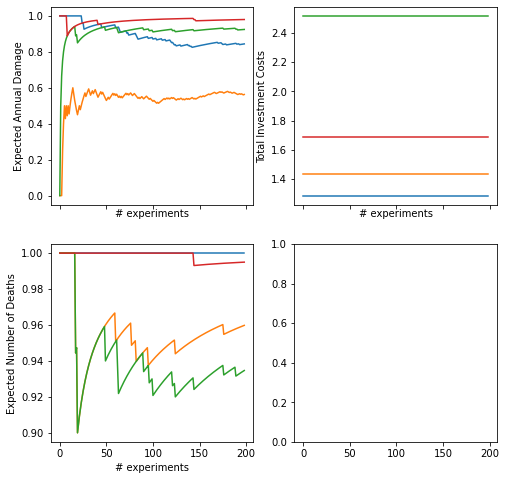

In [13]:
#Plotting the outcomes of the experiments
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

robustness_funcs = {
                    "Expected Number of Deaths": Expected_Number_of_Deaths,
                    "Expected Annual Damage": Expected_Annual_Damage,
                    "Total Investment Costs": Total_Investment_Costs
                    }

experiments, outcomes = results

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

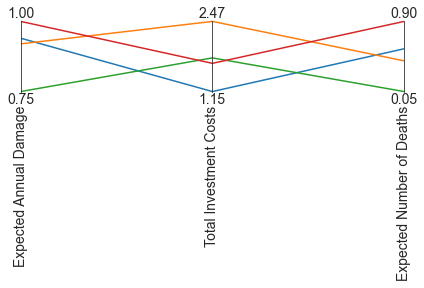

In [ ]:
#Plotting the outcomes of the experiments on parallel axes to better compare the policies


experiments, outcomes = results

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs
         }

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy

    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}

    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

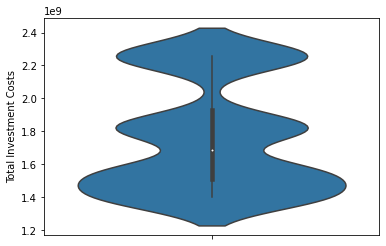

In [ ]:
#Plotting the total investment costs to see the distribution
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(data=data, y='Total Investment Costs')
plt.show()

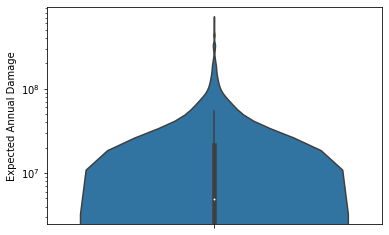

In [ ]:
#Plotting the Expected Annual Damage to see the distribution
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Annual Damage')
ax.set_yscale('log')
plt.show()

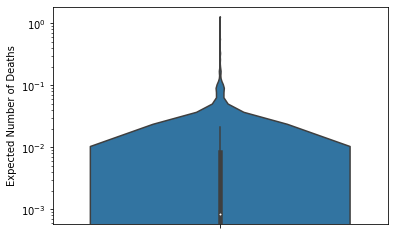

In [ ]:
#Plotting the Expected Number of Deaths to see the distribution
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Number of Deaths')
ax.set_yscale('log')
plt.show()

1.2 Optimization

In this section the values needed for experimentation, the epsilon, hypervolume and nfe, are chosen through experimentation. Then the model optimizes over a set of scenarios, thereby chosing the most robust policy. The policy that changes the least over all scenarios. 

In [7]:

#Defining the number of scenarios and nfe
n_scenarios = 10
scenarios = sample_uncertainties(model, n_scenarios)
nfe = int(2500)  

In [8]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('Expected Number of Deaths', kind=MAXIMIZE, #Maximize to find worst case scenario
                                     function=Expected_Number_of_Deaths),
                       ScalarOutcome('Expected Annual Damage', kind=MAXIMIZE,
                                     function=Expected_Annual_Damage),
                       ScalarOutcome('Total Investment Costs', kind=MAXIMIZE,
                                     function=Total_Investment_Costs),
                      ]
use_pickle4 = True
if use_pickle4:
    with open('data/moro_results7.pickle', 'rb') as filehandler:
        results4 = pickle.load(filehandler)
else:
    #Define convergence and HyperVolume
    convergence = [HyperVolume(minimum=[0, 0, 0], maximum=[1.01, 1.01, 3.01]),
    EpsilonProgress(),]
    #Define epsilons
    epsilons=[0.025,]*len(robustnes_functions) 
    #Optimize over random scenarios 
    with MultiprocessingEvaluator(model) as evaluator:
        results4 = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                         convergence=convergence, epsilons=epsilons)
    #Save results in Pickle file
    with open("data/moro_results7.pickle","wb") as filehandler:
        pickle.dump(results4, filehandler)
archive1, convergence = results4

In [9]:
#Values of variables of optimal policy
archive2 = archive1.T

archive2

,0
0_RfR 0,1.000000
0_RfR 1,1.000000
0_RfR 2,1.000000
1_RfR 0,1.000000
1_RfR 1,1.000000
1_RfR 2,1.000000
2_RfR 0,1.000000
2_RfR 1,1.000000
2_RfR 2,1.000000
3_RfR 0,1.000000


c:\Users\roosd\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(


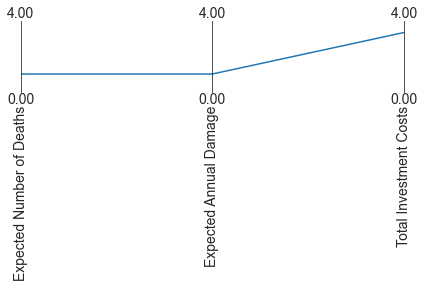

In [10]:
#Plot the optimal policy with parallel axis

data = archive1.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 4

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

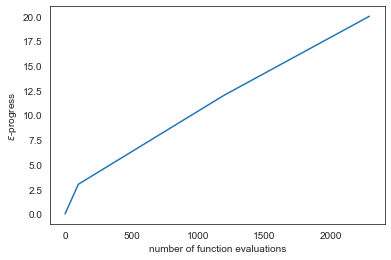

In [11]:
#Plot epsilon progress
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

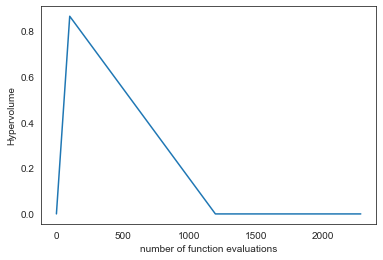

In [12]:
#Plot convergence
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.hypervolume)
ax.set_ylabel('Hypervolume')

ax.set_xlabel('number of function evaluations')
plt.show()

2 Robustness metrics

Using two robustness metrics, signal to noise ratio and maximum regret, the optimal policy is compared to three other policies over different scenarios. 

2.1 Running the experiments

In [22]:
#The data from the optimization is read in as a csv, 
#because not all python versions read in the pickles in the same way.
archive = pd.read_csv('data\moro_results7_archive.csv')


# with open('data/moro_results7.pickle', 'rb') as filehandler:
#         results = pickle.load(filehandler)
# archive,convergence=results

In [23]:
#A problem formulation is selected
used_problem_formulation = 3

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [37]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [38]:

#Selecting the policies to compare the optimal policy to
pol_list = []

location = '2'

pol_list.append(create_policy({"A.3_DikeIncrease 0": 10, f"{location}_RfR 0": 0, "EWS_DaysToThreat": 4},
                            name=f"Dike_{10}dm_RfR_{location}0_EWS_4d"))

pol_list.append(create_policy({"A.3_DikeIncrease 0": 0, f"{location}_RfR 0": 1, "EWS_DaysToThreat": 4},
                            name=f"Dike_{0}dm_RfR_{location}1_EWS_4d"))
                            
pol_list.append(create_policy({"A.3_DikeIncrease 0": 10, f"{location}_RfR 0": 1, "EWS_DaysToThreat": 4},
                            name=f"Dike_{10}dm_RfR_{location}1_EWS_4d"))    

In [39]:
policies = archive.iloc[:,:-3]

In [40]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    pol_list.append(Policy(str(i), **policy.to_dict()))

In [55]:
#Performing the experiments
n_scenarios = 1000
model, _ = get_model_for_problem_formulation(3)
use_pickle6 = True
if use_pickle6:
    with open('data/opt_analysis.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model, n_processes=8) as evaluator:
        results = evaluator.perform_experiments(n_scenarios,
                                                pol_list)
      # Save results in Pickle file
    with open("data/opt_analysis.pickle","wb") as filehandler:
        pickle.dump(results, filehandler) 

In [56]:
#dictionary to rename the policies
#so we don't have to run everything again
policy_dict = {
    'Policy_Dike_0dm_RfR_20_EWS_0d': 'Policy 0', 
    'Policy_Dike_0dm_RfR_20_EWS_4d': 'Policy 1: EWS',
    'Policy_Dike_0dm_RfR_21_EWS_0d': 'Policy 2: RfR', 
    'Policy_Dike_0dm_RfR_21_EWS_4d': 'Policy 3: RfR+EWS',
    'Policy_Dike_10dm_RfR_20_EWS_0d': 'Policy 4: Dike',
    'Policy_Dike_10dm_RfR_20_EWS_4d': 'Policy 5: Dike+EWS',
    'Policy_Dike_10dm_RfR_21_EWS_0d': 'Policy 6: Dike+RfR', 
    'Policy_Dike_10dm_RfR_21_EWS_4d': 'Policy 7: Dike+RfR+EWS',
    '0': 'Optimization policy'
    }


In [57]:
#selecting only the columns giving information about costs and deaths
experiments, outcomes = results


data = pd.DataFrame.from_dict(outcomes)
a = data.columns[data.columns.str.contains('Costs')]
data['Total Costs'] = data[a].sum(axis=1)
a = data.columns[data.columns.str.contains('Deaths')]
data['Total Deaths'] = data[a].sum(axis=1)
#renames the policies
experiments['policy'] = experiments.policy.map(policy_dict)
policies = experiments['policy']

data['policy'] = policies

In [58]:
#renaming the variable names
data.rename({
       'A.1 Total Costs': '1.C', 'A.1_Expected Number of Deaths': '1.D',
       'A.2 Total Costs': '2.C', 'A.2_Expected Number of Deaths': '2.D' , 'A.3 Total Costs': '3.C',
       'A.3_Expected Number of Deaths': '3.D', 'A.4 Total Costs': '4.C',
       'A.4_Expected Number of Deaths': '4.D', 'A.5 Total Costs': '5.C',
       'A.5_Expected Number of Deaths': '5.D'
       },axis=1, inplace=True)

In [59]:
pol_list = data['policy'].unique()

count=0
for i in pol_list:
    
    data.loc[data.policy== i, 'policy'] = count
    count+=1

In [60]:
#Defining limits for making a clear plot
limits = parcoords.get_limits(data.iloc[:,:-1])
dimensionlist = []

for column in limits:
    lower=0
    upper=limits[column].iloc[1]
    if upper>0:
        dimensionlist.append(dict(range = [lower,upper],
                label = column, values = data[column].values, tickformat = "~g"))
    else:
        dimensionlist.append(dict(range = [lower,0.1],
                label = column, values = data[column].values, tickformat = "~g"))

In [61]:
#Plotting the policies over the different scenarios

fig = go.Figure(data=
    go.Parcoords(line = dict(color = data['policy'], showscale=True),
                   dimensions= dimensionlist
                             ))
fig.show()

2.2 Signal to noise ratio

The signal to noise ratio shows the distribution of a policy across all scenarios. If the distribution is low it means that the difference between the scenarios is small.

In [62]:
#function for signal to noise ratio
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [63]:
experiments, outcomes = results

#first iterates over policies then over outcomes to calculate scores
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
Optimization policy,0.000000e+00,0.000000,7.297404e+13,7.380941e-12,5.741908e+00,0.000000e+00,6.638086e+12,7.528794e-13,2.759052e+13,1.197597e-11,0.0,1.234387e+01
Policy 3: RfR+EWS,1.402573e+18,0.009307,2.650311e+16,2.941737e-04,1.418894e+17,5.667185e-03,1.046297e+15,2.933401e-06,1.801175e+16,2.076145e-04,0.0,1.700310e+09
Policy 5: Dike+EWS,1.402573e+18,0.009307,3.958420e+16,4.516755e-04,1.361282e+14,1.286578e-08,1.189041e+15,3.382159e-06,2.113489e+16,2.440461e-04,0.0,8.294586e+08
Policy 7: Dike+RfR+EWS,1.402573e+18,0.009307,2.650311e+16,2.941737e-04,1.044927e+13,6.287721e-11,1.286461e+15,3.689779e-06,2.287821e+16,2.642087e-04,0.0,7.685056e+08


c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



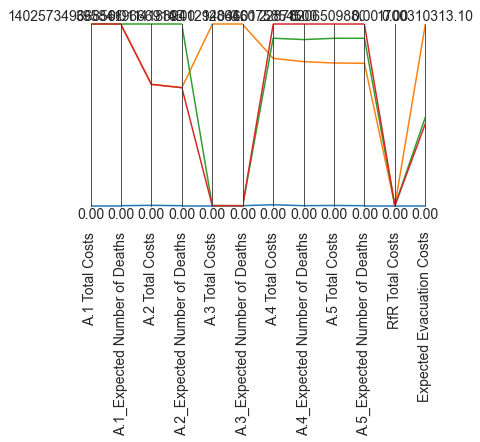

In [64]:
#plots the s/n ratio
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'
       ]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('max_P')
plt.show()

In [65]:
#Resetting the index
data.reset_index(inplace=True, drop=True)
data.reset_index(inplace=True)
data.columns.values[0] = "policy"

In [66]:
#Renaming the data 
data.rename({'A.1 Total Costs': '1.C', 'A.1_Expected Number of Deaths': '1.D',
       'A.2 Total Costs': '2.C', 'A.2_Expected Number of Deaths': '2.D' , 'A.3 Total Costs': '3.C',
       'A.3_Expected Number of Deaths': '3.D', 'A.4 Total Costs': '4.C',
       'A.4_Expected Number of Deaths': '4.D', 'A.5 Total Costs': '5.C',
       'A.5_Expected Number of Deaths': '5.D'},axis=1, inplace=True)

In [67]:
data2 = data.iloc[::-1,:]

In [68]:
#Defining limits for making a clear plot
limits = parcoords.get_limits(data.iloc[:,1::])
dimensionlist = []

for column in limits:
    lower=0
    upper=limits[column].iloc[1]
    if upper>0:
        dimensionlist.append(dict(range = [lower,upper],
                label = column, values = data[column].values, tickformat = "~g"))
    else:
        dimensionlist.append(dict(range = [lower,1],
                label = column, values = data[column].values, tickformat = "~g"))

In [69]:
#Plotting the signal to noise ratio

fig = go.Figure(data=
    go.Parcoords(line = dict(color = data['policy'],
                   colorscale = [[0,'yellow'],[0.5,'lightseagreen'],[1,'red']], showscale=True),
                   dimensions= dimensionlist
                             ))
fig.show()

2.3 Maximum regret

The maximum regret is the difference between the policy in a certain scenario and the best policy in the best case scenario. Put differently, how much regret one can have when chosing a certain policy, because an other one later turns out to be better.

In [70]:
#function to calculate regret
def calculate_regret(data, best):
    return np.abs(best-data)

In [71]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    coldict = {'A.1 Total Costs': '1.C', 'A.1_Expected Number of Deaths': '1.D',
       'A.2 Total Costs': '2.C', 'A.2_Expected Number of Deaths': '2.D' , 'A.3 Total Costs': '3.C',
       'A.3_Expected Number of Deaths': '3.D', 'A.4 Total Costs': '4.C',
       'A.4_Expected Number of Deaths': '4.D', 'A.5 Total Costs': '5.C',
       'A.5_Expected Number of Deaths': '5.D', 'RfR Total Costs': 'RfR', 'Expected Evacuation Costs':'Evac Costs'}

    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #

    outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[coldict.get(outcome.name)] = outcome_regret
    max_regret[coldict.get(outcome.name)] = outcome_regret.max()

C:\Users\hanna\AppData\Local\Temp\ipykernel_19600\1090543424.py:34: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\hanna\AppData\Local\Temp\ipykernel_19600\1090543424.py:34: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\hanna\AppData\Local\Temp\ipykernel_19600\1090543424.py:34: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\hanna\AppData\Local\Temp\ipykernel_19600\1090543424.py:34: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing in

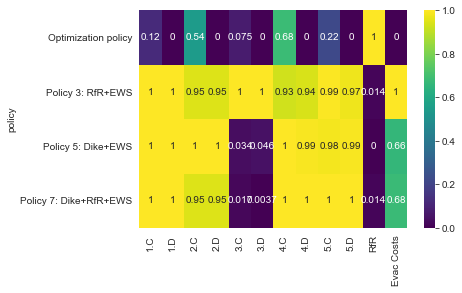

In [72]:
#Plot a heatmap of the maximum regret
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\parcoords.py:260: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



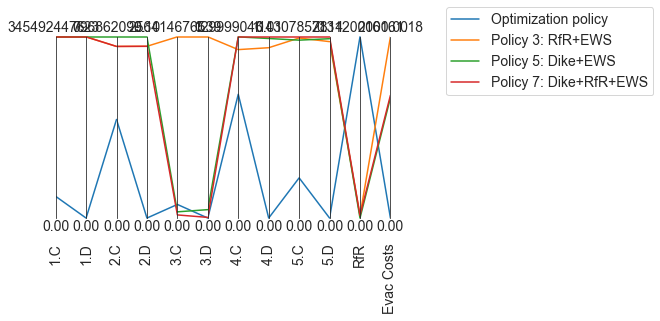

In [73]:
#Plot the maximum regret
colors = sns.color_palette()

data = max_regret

limits = parcoords.get_limits(data)
limits.loc[0, ['1.C', '1.D', '2.C', '2.D', '3.C', '3.D', '4.C', '4.D', '5.C',
       '5.D', 'RfR', 'Evac Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()